<a href="https://www.kaggle.com/code/dalloliogm/eda-exploring-cell-type-abundance?scriptVersionId=230203728" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Exploring Cell Type Abundance

This notebook reads all the slices in the training dataset, and creates a unified table containing all the cell abundancies. It then does some EDA analysis.

It also computes the rank of each cell type within a spot. Since this competition is evaluated using a Spearman Correlation, we are only interested in the relative abundance of each cell type compared to the others; so computing the rank can be useful.


### Summary of the EDA

- Cell type 30 is almost always the top cell type, in each slide. Cell types 1, 5, and 16 are almost always the least frequent types in a slide.
- Slides S4 and S5 are similar in terms of composition. Slide S2 is the most different to the others (based on PCA)
- At the end of the notebook I've written a function to plot the average rank of each cell type, taking into account its neighbours

### Read Data and create table

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd

def collect_all_train_spots(train_spot_tables):
    """
    Combine all spot tables from the training slides into a single DataFrame.
    Adds a 'slide' column to indicate the source slide for each spot.

    Parameters:
        train_spot_tables (dict): Dictionary where keys are slide names (e.g. 'S_1', 'S_2', ...)
                                  and values are structured NumPy arrays with fields: x, y, C1..C35.

    Returns:
        pd.DataFrame: Combined DataFrame with columns ['x', 'y', 'C1', ..., 'C35', 'slide']
    """
    all_spots = []

    for slide_name, spot_array in train_spot_tables.items():
        # Convert structured NumPy array to DataFrame
        spot_df = pd.DataFrame(spot_array)
        # Add slide name column
        spot_df.insert(0, "slide", slide_name)
        all_spots.append(spot_df)

    # Concatenate all into a single DataFrame
    combined_df = pd.concat(all_spots, ignore_index=True)
    return combined_df


In [2]:
with h5py.File("/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_spot_tables = h5file["spots/Train"]
    # Convert HDF5 datasets to NumPy arrays for each slide
    train_spot_arrays = {slide: np.array(train_spot_tables[slide]) for slide in train_spot_tables}

combined_df = collect_all_train_spots(train_spot_arrays)
combined_df.head()


,slide,x,y,C1,C2,C3,C4,C5,C6,C7,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,S_1,1554,1297,0.014401,0.057499,0.022033,0.001704,0.533992,1.511707,0.015313,...,0.001010,2.068237,0.121361,0.007344,0.000017,0.036891,0.035934,0.118937,0.001472,0.050057
1,S_1,462,1502,0.116196,0.197176,0.110600,0.042614,5.587681,0.006885,0.096346,...,0.000692,0.014442,0.000238,0.024071,0.000023,0.217589,0.100662,0.004027,0.004122,0.049491
2,S_1,1488,1548,0.133284,0.035880,0.061352,0.003073,1.104479,0.009174,0.009175,...,0.000096,0.149792,0.001401,0.000699,0.000009,0.024491,0.018810,0.004171,0.000425,0.015348
3,S_1,1725,1182,0.087715,0.235223,0.090382,0.013902,8.760482,0.140912,0.188859,...,0.001964,0.142549,0.002036,0.047165,0.000022,0.180372,0.202981,0.003709,0.001845,0.116022
4,S_1,581,1113,0.128468,0.066399,0.098982,0.047022,3.425771,0.001009,0.026881,...,0.000072,0.005920,0.000048,0.006359,0.000585,0.052661,0.032168,0.000107,0.000107,0.013103


In [3]:
combined_df.describe()

,x,y,C1,C2,C3,C4,C5,C6,C7,C8,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
count,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8.349000e+03,8.349000e+03,8.349000e+03,8349.000000,8.349000e+03,...,8.349000e+03,8.349000e+03,8.349000e+03,8.349000e+03,8.349000e+03,8349.000000,8349.000000,8.349000e+03,8.349000e+03,8349.000000
mean,1077.346029,1077.986825,1.315875,0.127599,0.910304,5.073074e-01,1.057699e+00,1.669755e-01,0.050874,1.636851e-02,...,4.191483e-02,2.641266e-01,2.531247e-02,7.156316e-02,7.365817e-02,0.112541,0.091504,3.406790e-02,3.005172e-02,0.063991
std,347.149079,302.559161,2.955853,0.172966,2.055712,1.182995e+00,1.837263e+00,4.400061e-01,0.071590,7.523105e-02,...,1.707578e-01,6.885651e-01,8.124566e-02,2.664217e-01,2.571422e-01,0.156569,0.124662,1.032217e-01,7.563085e-02,0.093024
min,270.000000,396.000000,0.000011,0.000261,0.000083,1.634036e-07,9.356235e-07,4.976576e-08,0.000005,8.606437e-08,...,6.357884e-08,4.521837e-08,1.031100e-08,8.827382e-09,4.018292e-09,0.000072,0.000026,1.908623e-08,4.217960e-08,0.000012
25%,832.000000,861.000000,0.016408,0.028648,0.020510,3.646352e-04,6.655373e-03,1.852336e-04,0.006909,1.403776e-04,...,1.637427e-04,1.549143e-04,1.207749e-04,2.238409e-04,8.077409e-06,0.018739,0.015590,1.176650e-04,3.846744e-04,0.008552
50%,1073.000000,1082.000000,0.069853,0.070915,0.067104,4.581381e-03,2.888173e-01,2.064704e-03,0.022202,9.930467e-04,...,1.198499e-03,3.077102e-03,1.204928e-03,2.638971e-03,8.205885e-05,0.054594,0.045107,1.199365e-03,3.066923e-03,0.027131
75%,1329.000000,1305.000000,0.812378,0.156029,0.530473,2.719029e-01,1.140192e+00,6.366868e-02,0.064301,6.876714e-03,...,1.222830e-02,1.065449e-01,1.199964e-02,2.557327e-02,5.066253e-03,0.135387,0.113888,1.593456e-02,2.195376e-02,0.077801
max,1830.000000,1800.000000,29.454552,2.314705,16.949463,9.771889e+00,1.588755e+01,6.475006e+00,0.675966,2.452402e+00,...,5.047303e+00,7.950480e+00,1.633818e+00,4.632741e+00,3.301860e+00,1.777416,1.274133,1.881064e+00,1.460682e+00,0.822354


In [4]:
ab_long = pd.wide_to_long(
        combined_df,
        stubnames="C",
        i=['slide', 'x', 'y'],
        j='cell_type',
        sep='',
        suffix='\\d+'
    ).reset_index()

ab_long.rename(columns={'C': 'abundance'}, inplace=True)
ab_long["rank"] = ab_long.groupby(["slide", "x", "y"])["abundance"].rank(method="dense", ascending=True)
ab_long

,slide,x,y,cell_type,abundance,rank
0,S_1,1554,1297,1,0.014401,12.0
1,S_1,1554,1297,2,0.057499,24.0
2,S_1,1554,1297,3,0.022033,18.0
3,S_1,1554,1297,4,0.001704,6.0
4,S_1,1554,1297,5,0.533992,30.0
...,...,...,...,...,...,...
292210,S_6,1186,864,31,0.048596,28.0
292211,S_6,1186,864,32,0.023379,23.0
292212,S_6,1186,864,33,0.044694,27.0
292213,S_6,1186,864,34,0.000392,8.0


In [5]:
composition_df = ab_long.groupby(["slide", "cell_type"])["abundance"].mean().unstack(fill_value=0)
composition_df

cell_type,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
slide,,,,,,,,,,,,,,,,,,,,,
S_1,0.121815,0.089254,0.093587,0.015726,1.699786,0.387921,0.037654,0.011725,0.751919,0.193413,...,0.026118,0.555403,0.042900,0.065627,0.002156,0.067414,0.062735,0.027981,0.013463,0.049265
S_2,4.291826,0.113044,2.972872,1.641658,0.736369,0.045590,0.074870,0.002172,0.046826,0.001683,...,0.005202,0.040083,0.005361,0.003858,0.000741,0.173707,0.135404,0.009075,0.058976,0.108704
S_3,0.725079,0.075951,0.466742,0.516227,0.432105,0.076716,0.019503,0.002872,0.047449,0.000630,...,0.016042,0.012360,0.001846,0.012357,0.003215,0.058641,0.046073,0.020889,0.016465,0.024181
S_4,0.135857,0.206737,0.093368,0.005385,2.025008,0.110981,0.078174,0.020068,0.705897,0.103831,...,0.039761,0.464360,0.052700,0.323093,0.050994,0.140262,0.112354,0.076050,0.025307,0.065912
S_5,0.177059,0.158723,0.118722,0.066009,0.031681,0.151110,0.030622,0.045922,0.388064,0.049421,...,0.112755,0.197721,0.023431,0.026668,0.304792,0.095392,0.079107,0.048721,0.025244,0.043664
S_6,0.053877,0.148292,0.043060,0.003385,2.042007,0.000755,0.044108,0.009622,0.000872,0.000694,...,0.101836,0.008181,0.005457,0.023727,0.105697,0.092254,0.063876,0.048681,0.011320,0.033918


## EDA Analysis

### How often is each Cell type ranked top or last?

Some cell types may be present in all slices, and some may never be. 

It seems that Cell 30 is almost always the top cell type in the slice. It may be 

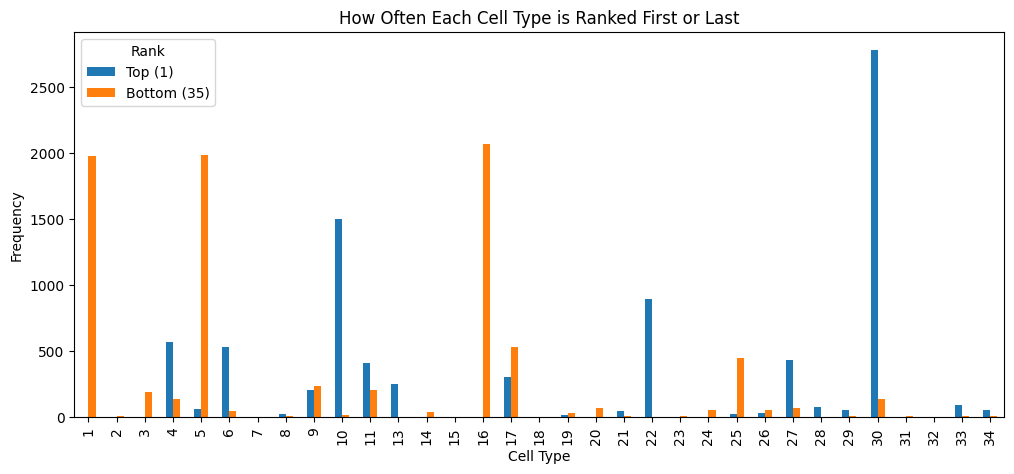

In [6]:
# Count how often each cell type was ranked #1 or #35
rank_counts = ab_long[ab_long["rank"].isin([1, 35])].groupby(["cell_type", "rank"]).size().unstack(fill_value=0)

# Bar plot
rank_counts.plot(kind="bar", figsize=(12, 5))
plt.title("How Often Each Cell Type is Ranked First or Last")
plt.xlabel("Cell Type")
plt.ylabel("Frequency")
plt.legend(title="Rank", labels=["Top (1)", "Bottom (35)"])
plt.show()


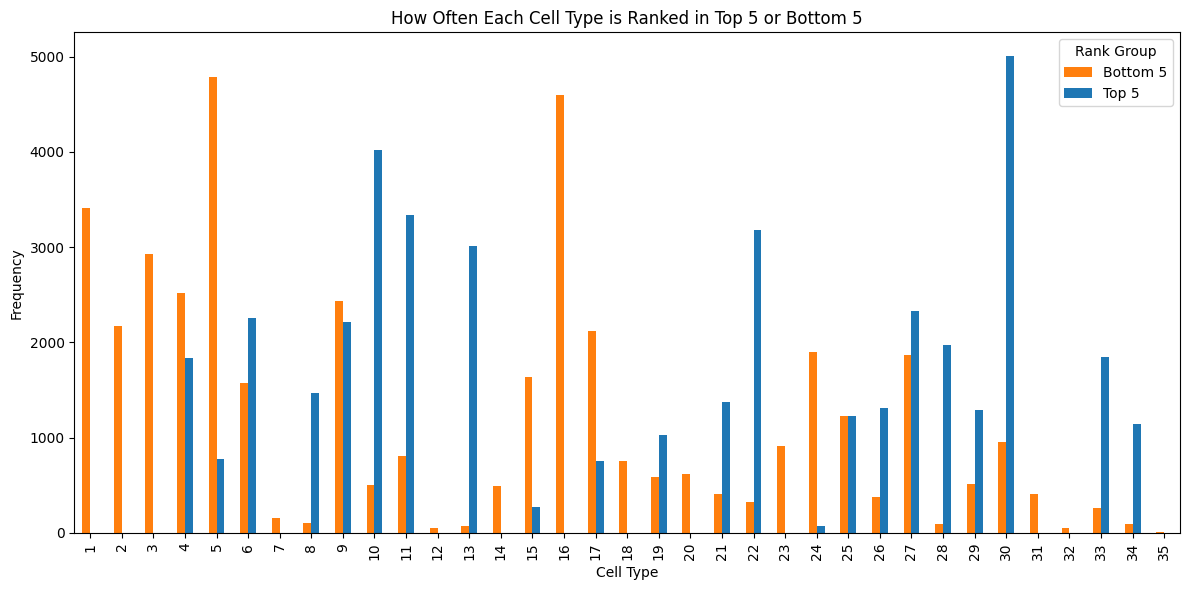

In [7]:
# Define top and bottom rank ranges
top_ranks = list(range(1, 6))       # 1 to 5
bottom_ranks = list(range(31, 36))  # 31 to 35

# Label ranks as 'Top 5' or 'Bottom 5'
ab_long["rank_group"] = ab_long["rank"].apply(
    lambda r: "Top 5" if r in top_ranks else ("Bottom 5" if r in bottom_ranks else None)
)

# Filter to just Top 5 and Bottom 5
rank_subset = ab_long[ab_long["rank_group"].notnull()]

# Count occurrences per cell type and rank group
rank_counts = rank_subset.groupby(["cell_type", "rank_group"]).size().unstack(fill_value=0)

# Bar plot
rank_counts.plot(kind="bar", figsize=(12, 6), color=["#ff7f0e","#1f77b4"])
plt.title("How Often Each Cell Type is Ranked in Top 5 or Bottom 5")
plt.xlabel("Cell Type")
plt.ylabel("Frequency")
plt.legend(title="Rank Group")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


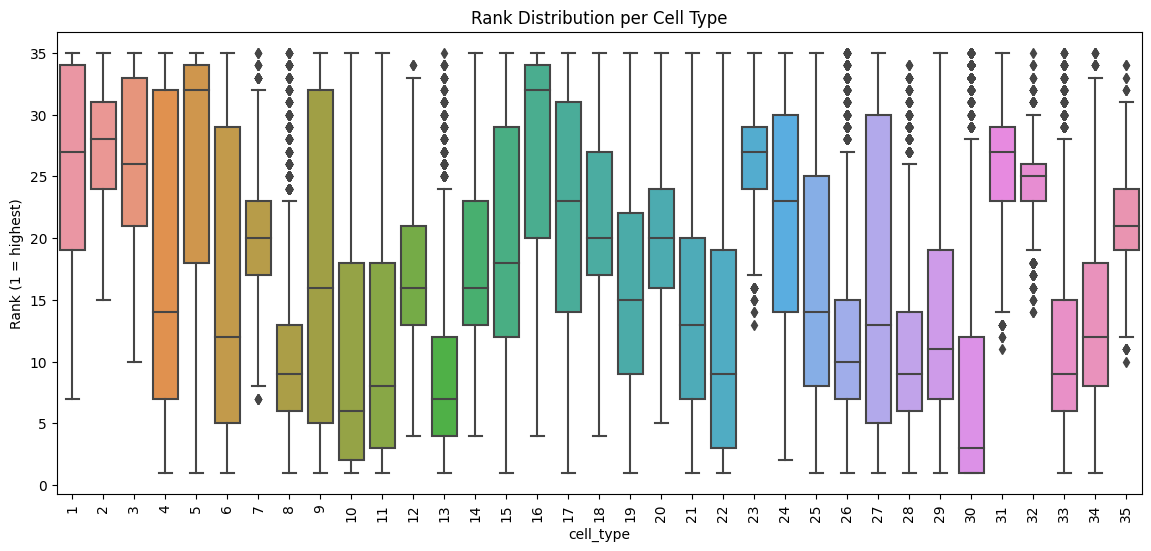

In [8]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=ab_long, x="cell_type", y="rank", order=sorted(ab_long["cell_type"].unique()))
plt.xticks(rotation=90)
plt.title("Rank Distribution per Cell Type")
plt.ylabel("Rank (1 = highest)")
plt.show()


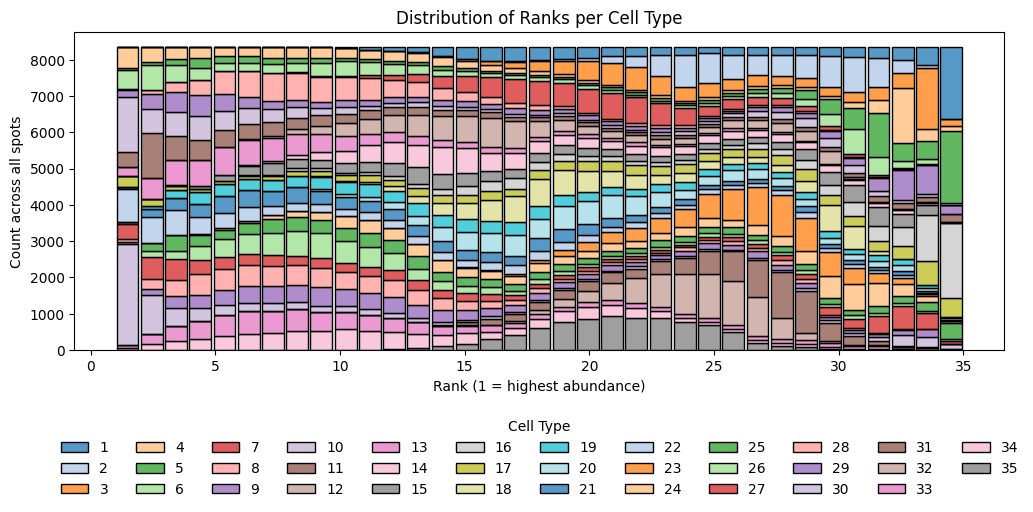

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

plt.figure(figsize=(12, 6))
plot = sns.histplot(
    data=ab_long,
    x="rank",
    hue="cell_type",
    bins=35,
    multiple="stack",
    palette="tab20",
    shrink=0.9
)
plt.title("Distribution of Ranks per Cell Type")
plt.xlabel("Rank (1 = highest abundance)")
plt.ylabel("Count across all spots")

## Access the legend from the plot object
#legend = plot.get_legend()

sns.move_legend(
    plot, "lower center",
    bbox_to_anchor=(.5, -0.5), ncol=12, title="Cell Type", frameon=False,
)

plt.subplots_adjust(bottom=0.35)
plt.show()

## Similarity across slides

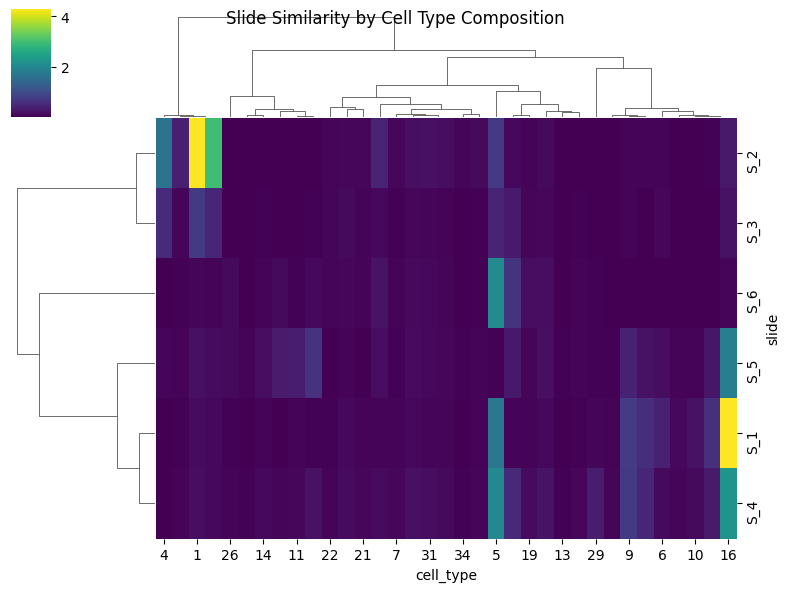

In [10]:
import seaborn as sns
sns.clustermap(composition_df, metric="cosine", cmap="viridis", figsize=(8, 6))
plt.suptitle("Slide Similarity by Cell Type Composition")
plt.show()


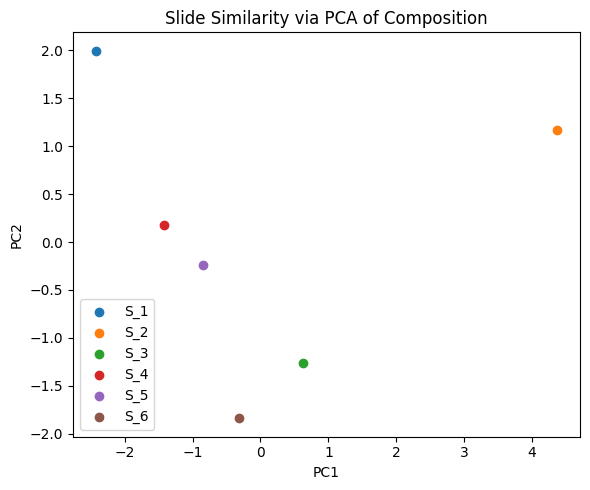

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(composition_df)

plt.figure(figsize=(6, 5))
for i, slide in enumerate(composition_df.index):
    plt.scatter(coords[i, 0], coords[i, 1], label=slide)
plt.legend()
plt.title("Slide Similarity via PCA of Composition")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [12]:
rank_matrix = ab_long.groupby(["slide", "cell_type"])["rank"].mean().unstack(fill_value=np.nan)
rank_matrix

cell_type,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
slide,,,,,,,,,,,,,,,,,,,,,
S_1,22.093764,26.725990,23.497041,13.231680,27.484297,21.965863,20.132909,9.988166,26.012289,19.763769,...,10.034593,24.672280,12.609467,18.122440,3.095130,23.246245,23.690942,11.101957,9.438325,21.463359
S_2,33.964758,25.630396,33.221145,31.260352,30.935683,12.781057,21.455507,8.672687,11.155066,3.856388,...,10.334361,10.566079,8.837004,8.411454,3.709251,27.371806,25.355947,9.307930,18.713656,23.078414
S_3,31.272464,26.971014,30.649275,25.233333,30.462319,13.824638,19.484058,8.707246,16.521739,3.343478,...,11.807246,11.366667,7.092754,11.689855,7.094203,25.888406,23.778261,11.505797,13.872464,20.355072
S_4,20.267902,28.758214,22.156698,8.736310,27.917439,14.238416,20.694187,11.185341,18.508003,12.245998,...,11.224094,16.962089,12.718618,20.311710,10.735468,25.393429,24.326032,14.039596,10.119629,20.611626
S_5,23.455575,29.199165,23.205725,8.882528,12.212284,13.204532,17.834824,14.097794,18.440072,11.301729,...,18.125224,13.612999,13.330352,11.501491,22.485391,25.461538,24.273107,13.772212,11.813953,19.992844
S_6,21.460366,31.152439,23.695122,8.682927,32.329268,4.932927,23.765244,11.277439,5.823171,2.695122,...,16.655488,8.307927,8.353659,16.006098,14.841463,28.567073,25.804878,16.240854,10.466463,21.484756


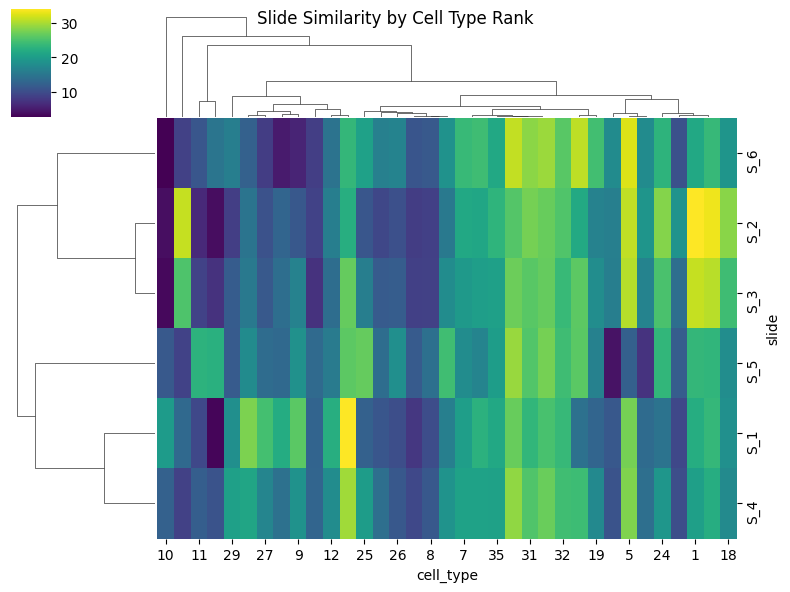

In [13]:
import seaborn as sns
sns.clustermap(rank_matrix, metric="cosine", cmap="viridis", figsize=(8, 6))
plt.suptitle("Slide Similarity by Cell Type Rank")
plt.show()


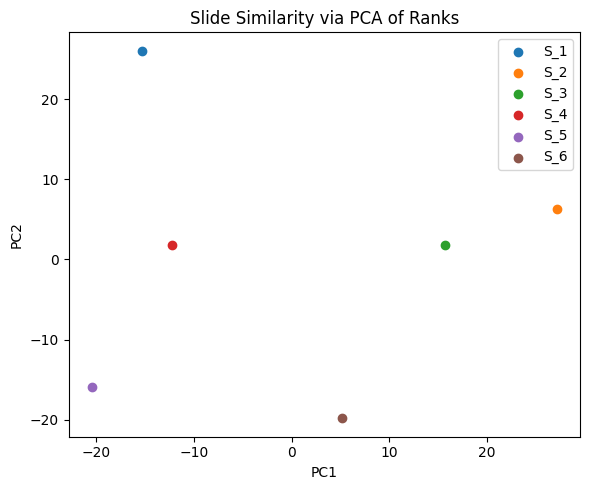

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(rank_matrix)

plt.figure(figsize=(6, 5))
for i, slide in enumerate(composition_df.index):
    plt.scatter(coords[i, 0], coords[i, 1], label=slide)
plt.legend()
plt.title("Slide Similarity via PCA of Ranks")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## Smoothing Ranks by Neighbours

Here we integrate the spatial information with the ranking. For every spot, we compute the rank of each cell type, averaged with the rank of the nearby cells.

In [15]:
from scipy.spatial import KDTree
import pandas as pd
import numpy as np
from tqdm import tqdm

def smooth_by_neighbors(df, value_col="rank", radius=100):
    """
    For each spot, compute the average `value_col` (e.g. 'rank' or 'abundance') among neighbors within radius.
    
    Parameters:
        df: long-format DataFrame with columns: ['slide', 'x', 'y', 'cell_type', value_col]
        value_col: the name of the column to average over neighbors
        radius: radius for neighbor search (same units as x, y coords)
        
    Returns:
        A copy of the DataFrame with a new column: 'smoothed_<value_col>'
    """
    df = df.copy()
    df[f"smoothed_{value_col}"] = np.nan

    for slide in df["slide"].unique():
        for cell_type in df["cell_type"].unique():
            subset = df[(df["slide"] == slide) & (df["cell_type"] == cell_type)].copy()
            coords = subset[["x", "y"]].values
            values = subset[value_col].values
            tree = KDTree(coords)

            smoothed = []
            for i in range(len(coords)):
                idx = tree.query_ball_point(coords[i], r=radius)
                if idx:
                    avg = np.mean(values[idx])
                else:
                    avg = np.nan
                smoothed.append(avg)

            df.loc[subset.index, f"smoothed_{value_col}"] = smoothed

    return df


In [16]:
ab_long_smoothed = smooth_by_neighbors(ab_long, value_col="rank", radius=100)


In [17]:
ab_long_smoothed

,slide,x,y,cell_type,abundance,rank,rank_group,smoothed_rank
0,S_1,1554,1297,1,0.014401,12.0,None,23.407407
1,S_1,1554,1297,2,0.057499,24.0,None,24.925926
2,S_1,1554,1297,3,0.022033,18.0,None,22.574074
3,S_1,1554,1297,4,0.001704,6.0,None,12.166667
4,S_1,1554,1297,5,0.533992,30.0,None,28.018519
...,...,...,...,...,...,...,...,...
292210,S_6,1186,864,31,0.048596,28.0,None,28.796296
292211,S_6,1186,864,32,0.023379,23.0,None,25.722222
292212,S_6,1186,864,33,0.044694,27.0,None,16.018519
292213,S_6,1186,864,34,0.000392,8.0,None,10.370370


In [18]:
import matplotlib.pyplot as plt

def plot_smoothed_celltype_all_slides(df, cell_type, value_col="smoothed_rank", cmap="plasma", cols=3, vmin=1, vmax=35):
    """
    Plot smoothed values for a single cell type across all slides, with a consistent color scale.

    Parameters:
        df (pd.DataFrame): DataFrame with ['slide', 'x', 'y', 'cell_type', value_col']
        cell_type (int): Cell type ID to visualize (e.g. 17)
        value_col (str): Column to color by ('smoothed_rank' or 'abundance')
        cmap (str): Matplotlib colormap
        cols (int): Number of plots per row
        vmin, vmax (float): Fixed color scale range (e.g. 1–35 for ranks)
    """
    slides = df["slide"].unique()
    n = len(slides)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), squeeze=False)
    axes = axes.flatten()

    for i, slide in enumerate(slides):
        ax = axes[i]
        data = df[(df["slide"] == slide) & (df["cell_type"] == cell_type)]

        sc = ax.scatter(data["x"], data["y"], c=data[value_col], cmap=cmap, s=10, alpha=0.9, vmin=vmin, vmax=vmax)
        ax.set_title(f"{slide}")
        ax.invert_yaxis()
        ax.axis("off")

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Add a shared colorbar
    cbar = fig.colorbar(sc, ax=axes.tolist(), orientation="horizontal", fraction=0.05, pad=0.05)
    cbar.set_label(f"{value_col} (rank 1 = most abundant)")

    fig.suptitle(f"Cell Type {cell_type} – {value_col}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


<ipython-input-18-4bcc27974602>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


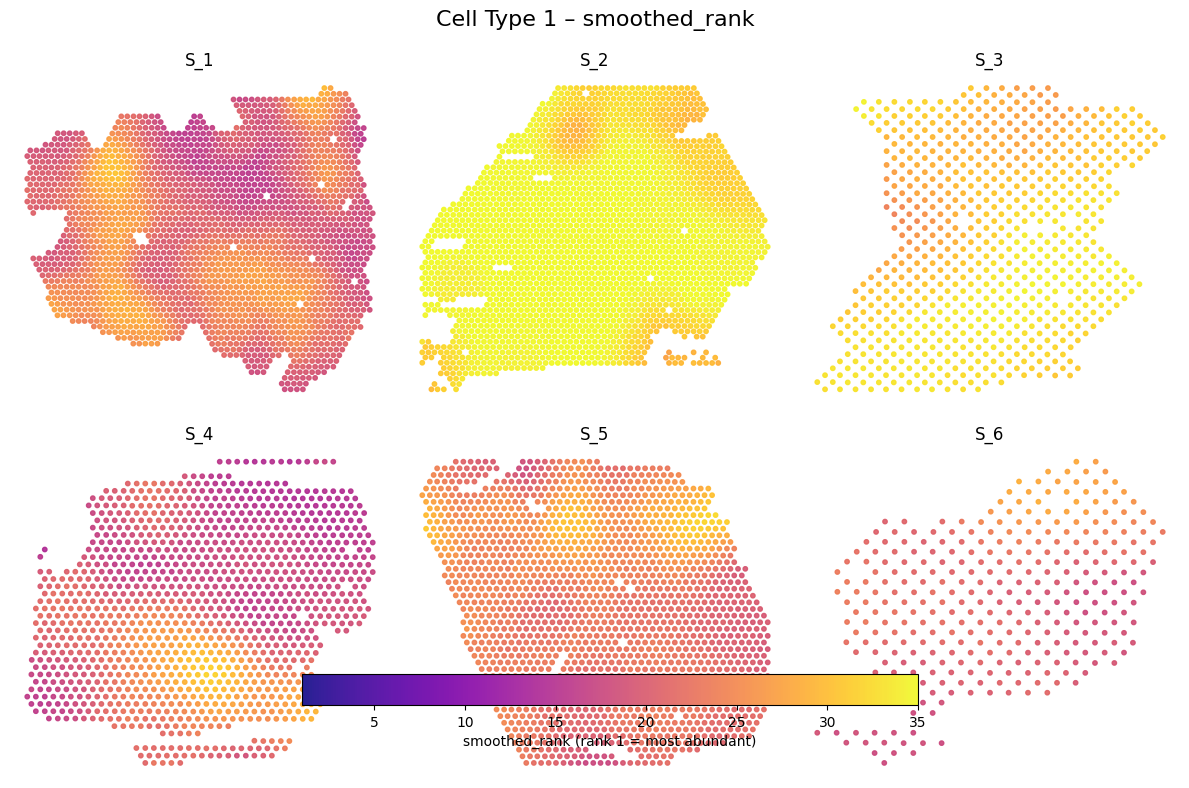

In [19]:
plot_smoothed_celltype_all_slides(ab_long_smoothed, cell_type=1, value_col="smoothed_rank")


<ipython-input-18-4bcc27974602>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


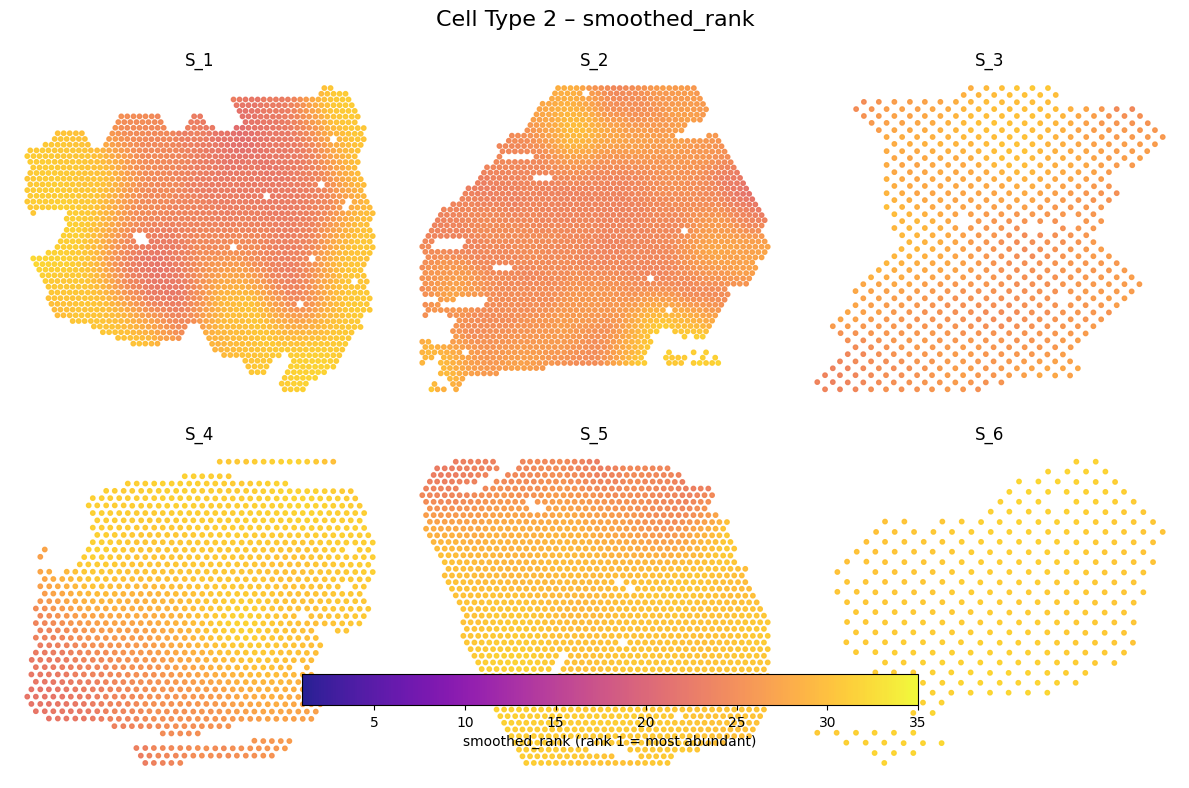

In [20]:
plot_smoothed_celltype_all_slides(ab_long_smoothed, cell_type=2, value_col="smoothed_rank")


<ipython-input-18-4bcc27974602>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


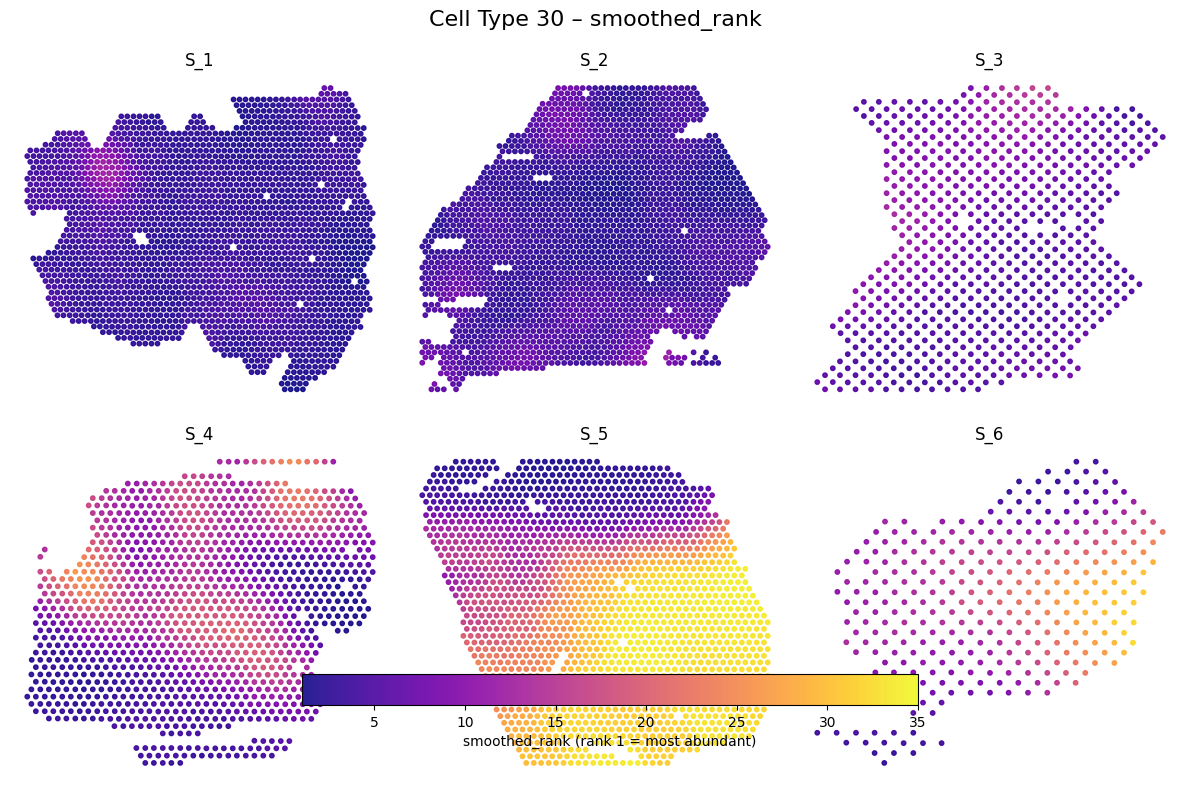

In [21]:
plot_smoothed_celltype_all_slides(ab_long_smoothed, cell_type=30, value_col="smoothed_rank")


## Generating a pseudo submission file

Here we randomly generate a submission file, taking into account the neighbour averaged ranks computed above.

In [22]:
avg_rank_by_cell = ab_long_smoothed.groupby("cell_type")["smoothed_rank"].mean()


In [23]:
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
from tqdm import tqdm

def predict_test_from_train(train_df, test_spot_table, radius=100, seed=None):
    """
    Generate a realistic test submission using spatial neighbors from training data.

    Parameters:
        train_df (pd.DataFrame): long-format train data with ['x', 'y', 'cell_type', 'smoothed_rank']
        test_spot_table (pd.DataFrame): Test spot DataFrame with 'x', 'y' columns
        radius (float): Radius in pixels for neighbor search
        seed (int, optional): Random seed for reproducibility

    Returns:
        pd.DataFrame: Submission DataFrame with predicted ranks (columns C1 to C35), indexed by test spot ID
    """
    if seed is not None:
        np.random.seed(seed)

    # Pivot to wide format: (x, y) → smoothed_rank for each cell type
    rank_table = train_df.pivot_table(index=["x", "y"], columns="cell_type", values="smoothed_rank")
    rank_table = rank_table.dropna(how="any")  # drop incomplete rows

    # Build KDTree
    train_coords = np.array(rank_table.index.tolist())
    tree = KDTree(train_coords)

    # Get cell type column names C1 to C35
    cell_types = [f"C{i}" for i in range(1, 36)]
    cell_type_ids = list(range(1, 36))

    # Init output
    test_indices = test_spot_table.index
    pred_df = pd.DataFrame(index=test_indices, columns=cell_types, dtype=float)

    # Fallback: average smoothed rank per cell type
    avg_rank_by_cell = train_df.groupby("cell_type")["smoothed_rank"].mean().reindex(cell_type_ids)

    # Iterate through test spots
    for idx in tqdm(test_spot_table.index, desc="Generating Test Predictions"):
        x, y = test_spot_table.loc[idx, ["x", "y"]]
        neighbors = tree.query_ball_point([x, y], r=radius)

        if neighbors:
            neighbor_ranks = rank_table.iloc[neighbors]
            pred = neighbor_ranks.mean().to_numpy()
        else:
            pred = avg_rank_by_cell.to_numpy()

        # Clip or round to stay within valid rank range
        pred = np.clip(pred, 1, 35)

        pred_df.loc[idx] = pred

    return pred_df


In [24]:
# Prepare test spot DataFrame from HDF5
with h5py.File("/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5", "r") as h5file:
    test_spot_table = pd.DataFrame(h5file["spots/Test/S_7"][:])

submission_df = predict_test_from_train(ab_long_smoothed, test_spot_table, radius=120, seed=42)

# Format for submission
submission_df.index.name = "ID"
submission_df.reset_index().to_csv("submission.csv", index=False)


Generating Test Predictions: 100%|██████████| 2088/2088 [00:02<00:00, 880.78it/s]


In [25]:
submission_df

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
ID,,,,,,,,,,,,,,,,,,,,,
0,26.703148,26.990934,26.422679,15.689038,21.766061,14.424086,19.393590,11.116397,15.905449,12.398249,...,14.682987,14.245245,12.021503,11.064375,13.311695,24.905967,24.259010,12.322724,13.368605,21.716895
1,27.821648,28.320008,27.694081,17.397515,31.320826,14.899157,20.857102,8.356731,19.677891,10.526997,...,10.152933,17.164444,7.476835,13.447512,5.452220,26.067289,24.167694,9.684981,12.010358,20.682217
2,26.562985,28.210898,27.220736,18.666798,30.188387,11.553320,22.266116,10.046958,15.896131,7.253411,...,11.070399,11.915817,11.051585,12.295893,9.306953,27.398795,24.878664,10.959528,12.715056,21.606515
3,28.745202,25.858538,27.677172,20.385129,28.775670,19.976573,19.096948,8.986454,22.205907,13.367142,...,11.025913,20.142400,11.399179,11.230127,5.618759,24.424742,23.680458,9.712679,13.279923,21.087943
4,25.586027,29.793788,26.741962,17.249755,32.242769,11.420483,22.670955,9.897245,16.820025,5.956512,...,9.171169,11.634982,5.756701,15.850514,4.909681,27.361647,24.863953,8.697462,11.243624,21.079710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,28.936374,26.961767,27.901667,17.476284,23.558456,23.689402,17.005134,9.662358,23.823744,10.048737,...,11.688580,18.837438,12.915447,9.996084,8.494821,25.283084,24.272149,7.997035,16.268775,20.864543
2084,27.371746,28.234769,26.952826,16.101909,25.363649,18.353984,18.542817,11.265345,21.836934,7.934238,...,11.914194,17.218740,10.953779,11.755878,8.820937,25.827441,24.444141,9.456139,13.513783,20.849958
2085,24.904528,27.727720,25.241615,14.956103,24.803785,13.879053,19.794862,10.978145,17.155189,10.189950,...,13.380177,15.392959,12.571741,14.745982,11.844844,25.580161,24.580464,12.734652,12.460245,21.587388


In [26]:
# Reset index if needed
submission_long = submission_df.copy()
submission_long["ID"] = submission_df.index

# Melt the predictions into long format
submission_long = submission_long.melt(
    id_vars="ID",
    var_name="cell_type",
    value_name="predicted_rank"
)

# Merge with test coordinates
submission_long = submission_long.merge(
    test_spot_table.reset_index()[["ID", "x", "y"]],
    on="ID"
)


In [27]:
def plot_predicted_ranks_on_test_slide(df, cell_type, value_col="predicted_rank", cmap="plasma"):
    """
    Visualize predicted ranks for a specific cell type on the test slide.

    Parameters:
        df (pd.DataFrame): long-format DataFrame with ['x', 'y', 'cell_type', value_col]
        cell_type (int): cell type ID (e.g. 17)
        value_col (str): predicted rank column to color by
        cmap (str): colormap for plotting
    """
    data = df[df["cell_type"] == cell_type]

    plt.figure(figsize=(6, 6))
    sc = plt.scatter(data["x"], data["y"], c=data[value_col], cmap=cmap, s=10, alpha=0.9, vmin=1, vmax=35)
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.colorbar(sc, label=value_col)
    plt.title(f"Predicted Ranks on Test Slide – Cell Type {cell_type}")
    plt.tight_layout()
    plt.show()


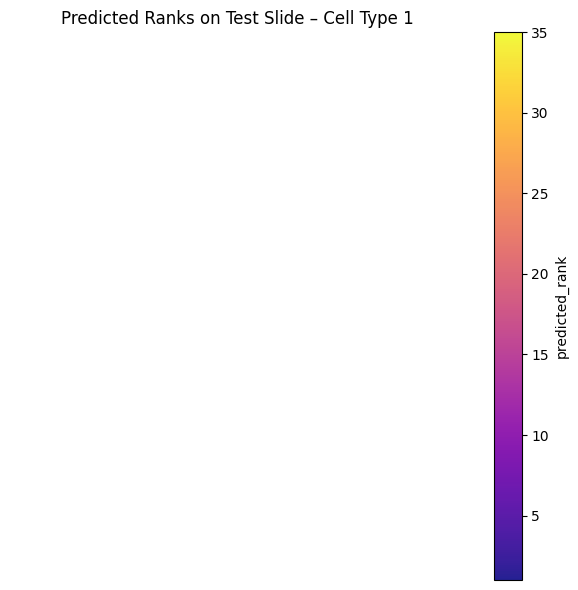

In [28]:
plot_predicted_ranks_on_test_slide(submission_long, cell_type=1)


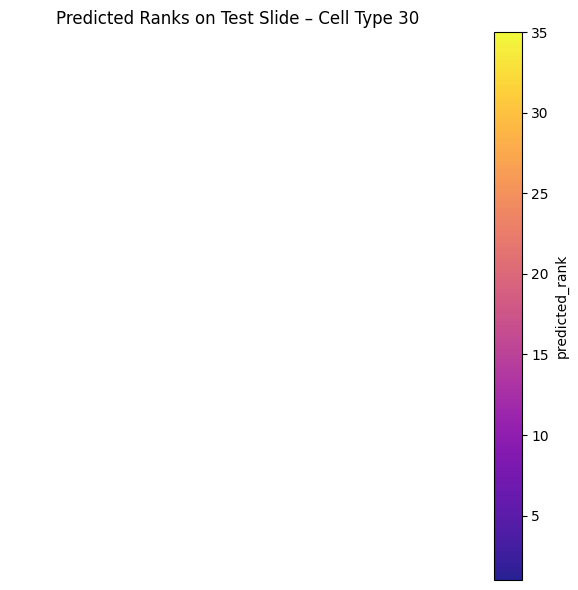

In [29]:
plot_predicted_ranks_on_test_slide(submission_long, cell_type=30)


In [30]:
!head submission.csv

ID,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,26.703148262717896,26.990933805565252,26.42267942385166,15.68903776380098,21.76606084181837,14.424085725685405,19.393590451847928,11.116397282506703,15.905448885321116,12.398249281234861,15.558884392320259,17.634227631510626,9.487421273825182,20.300454277190802,17.21555931965304,24.65349384448183,23.156636507410965,21.93777218906817,16.26835949289312,19.34363091627341,12.284357850247295,10.918049666506093,25.92946090427196,23.534854503881718,19.06819973854629,14.682986513206771,14.245245479877703,12.021502822635508,11.06437481583545,13.311695194377247,24.905966929512562,24.25900956654741,12.32272434646839,13.368604794620433,21.716895304487608
1,27.821648027944693,28.320007821603035,27.694081452922752,17.39751488098741,31.320826441470558,14.899157443668098,20.857102232193895,8.356730746685626,19.677890758356334,10.526997155153289,13.06342120689891,17.89